In [5]:
# 한글폰트 설정
from matplotlib import font_manager, rc

# 1. 한글 폰트 설정 (Windows의 '맑은 고딕' 폰트)
font_path = "c:/Windows/Fonts/malgun.ttf"  # 폰트 경로 (맑은 고딕)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)



### 단일모델 테스트

In [7]:
print(os.getcwd())

c:\Users\Sesame\food_yolo_detection\seg_test



0: 640x640 1 01011001, 1 06012004, 3 07014001s, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 11013007, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 11013007, 25.0ms
Speed: 3.0ms preprocess, 25.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 04017001, 2 06012004s, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 11013007, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 04017001, 6 06012004s, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 1 04017001, 3 06012004s, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.0ms
S

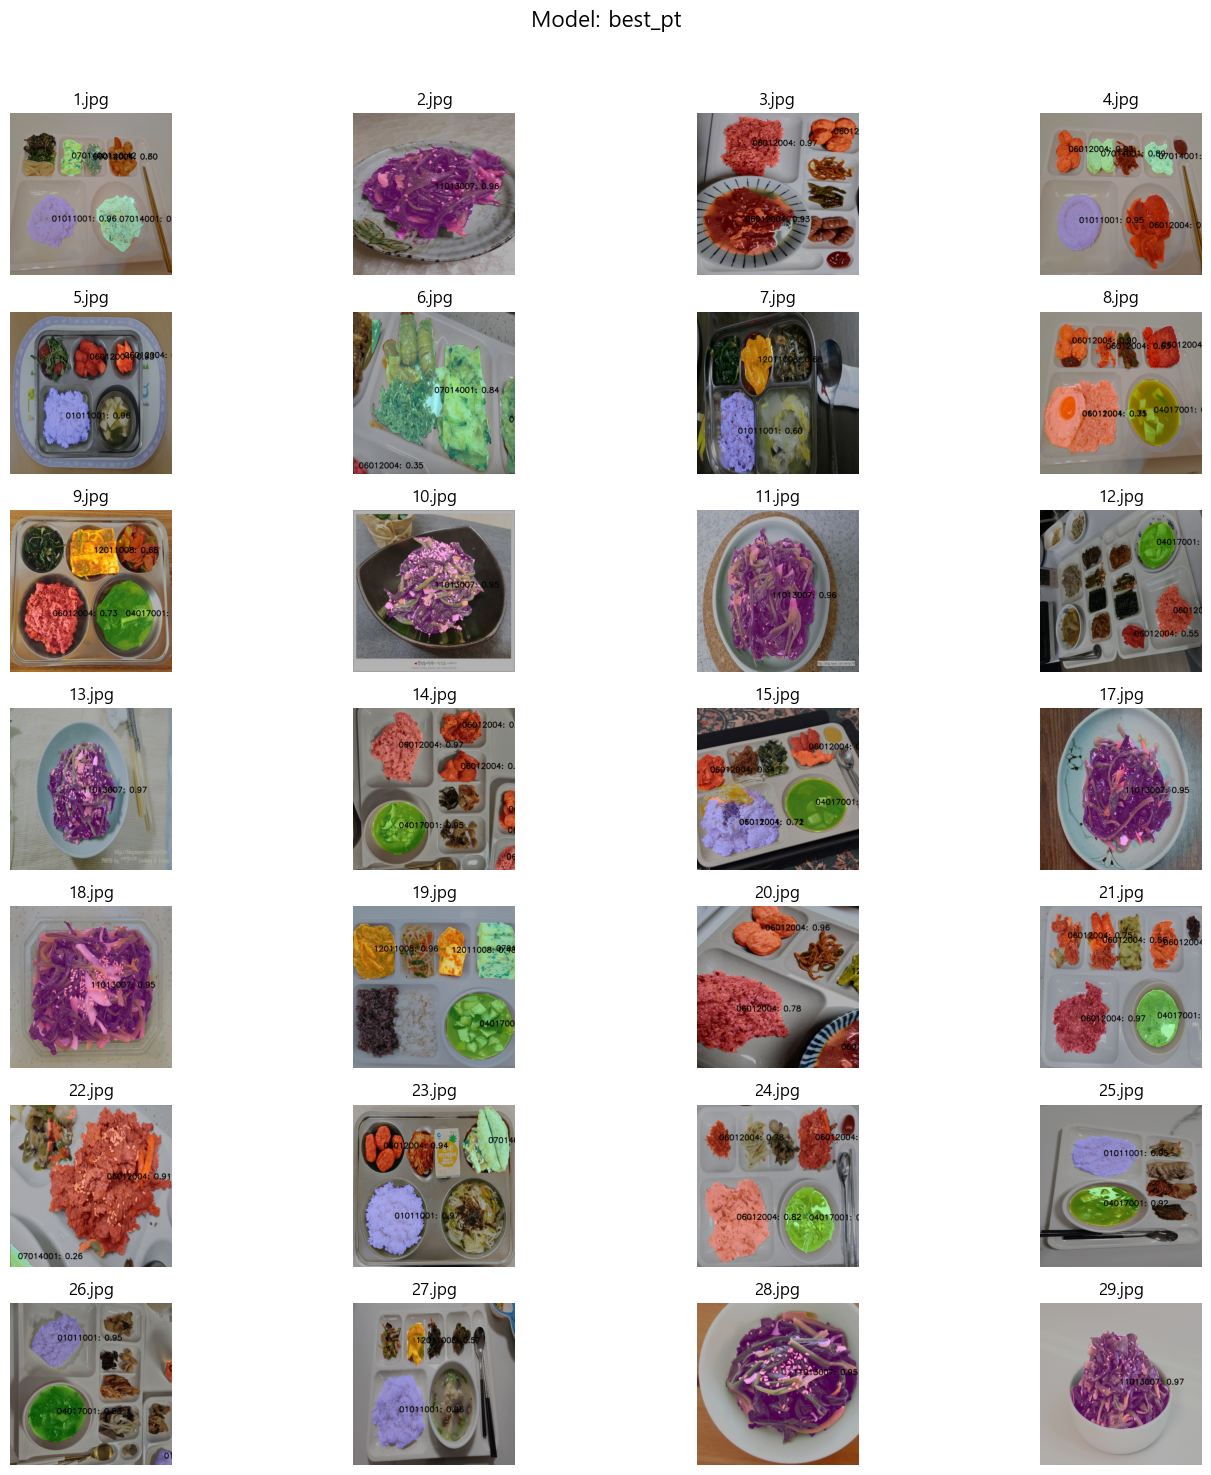

In [58]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# 1. 모델 경로 정의
model_path = 'best_pt/best.pt'  # 모델 파일 경로

# 2. 테스트할 이미지 파일 경로 정의
image_folder = 'real_test_image'
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 클래스별 색상 정의 (6개 클래스)
colors = [
    (255, 0, 0),   # Class 0 - Red
    (0, 255, 0),   # Class 1 - Green
    (0, 0, 255),   # Class 2 - Blue
    (255, 255, 0), # Class 3 - Cyan
    (255, 0, 255), # Class 4 - Magenta
    (0, 255, 255)  # Class 5 - Yellow
]

# 모델 불러오기
if os.path.exists(model_path):
    model = YOLO(model_path)
    model_name = os.path.basename(os.path.dirname(model_path))  # 모델 이름으로 폴더 이름 사용(필요시 사용)

    # 예측 결과를 저장할 리스트
    processed_images = []

    # 각 이미지에 대해 예측 수행
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (640, 640))  # 이미지 크기 조정

        # 모델 예측 수행
        results = model(resized_image)

        
        # 예측 결과 시각화
        for result in results:
            if result.masks is None:
                print("탐지되는 객체 없음")
                continue
            masks = result.masks.data.cpu().numpy()  # 마스크 데이터 (N, H, W)
            boxes = result.boxes  # 탐지된 객체의 정보
            # print(masks)
            # 마스크를 RGB 이미지로 변환
            segmentation_image = np.zeros_like(resized_image, dtype=np.uint8)
            for i, mask in enumerate(masks):  # 객체별 마스크 처리
                class_id = int(boxes.cls[i].item())  # 클래스 ID
                confidence = boxes.conf[i].item()  # 신뢰도
                color = colors[class_id]  # 클래스에 따른 색상 선택

                # 객체 마스크 색상화
                segmentation_image[mask > 0.5] = color

            # 원본 이미지와 마스크 오버레이
            overlay_image = cv2.addWeighted(resized_image, 0.7, segmentation_image, 0.3, 0)    

            for i, mask in enumerate(masks):
                class_id = int(boxes.cls[i].item())
                confidence = boxes.conf[i].item()

                # 마스크 중앙에 텍스트 삽입
                y_coords, x_coords = np.where(mask > 0.5)  # 마스크 영역 좌표
                if len(x_coords) > 0 and len(y_coords) > 0:
                    x_center = int(np.mean(x_coords))
                    y_center = int(np.mean(y_coords))
                    text = f"{model.names[class_id]}: {confidence:.2f}"
                    cv2.putText(overlay_image, text, (x_center, y_center),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2, cv2.LINE_AA)


            # RGB로 변환 후 처리된 이미지를 저장
            processed_images.append((cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB), f"{model_name} - {image_file}"))


# 3. 여러 이미지를 n행 × n열 그리드로 시각화하는 함수 정의
def plot_grid(images_with_titles, rows, cols, grid_title):
    """이미지를 숫자 기준으로 정렬한 후 n행 × n열 그리드로 표시, 그리드 제목 포함"""
    # 숫자를 기준으로 정렬
    images_with_titles_sorted = sorted(
        images_with_titles,
        key=lambda x: int(''.join(filter(str.isdigit, x[1]))),  # 제목에서 숫자 추출 후 정렬
    )

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # 그리드 생성

    # 각 이미지에 대해 축 설정
    for i, (img, title) in enumerate(images_with_titles_sorted):
        ax = axes.flatten()[i] if i < rows * cols else None
        if ax:
            ax.imshow(img)  # 이미지 표시
            ax.set_title(title.split(' ')[-1])  # 파일명 표시
            ax.axis('off')  # 축 숨기기

    # 그리드 전체의 제목 설정
    fig.suptitle(grid_title, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목 공간 확보
    plt.show()



# 4. 예측 결과를 그리드로 시각화
total_images = len(processed_images)
cols = 4  # 한 줄에 표시할 이미지 수
rows = (total_images // cols) + 1 if total_images % cols != 0 else total_images // cols

# 예측 결과를 그리드로 시각화, 그리드에 모델 이름을 제목으로 설정
plot_grid(processed_images, rows=rows, cols=cols, grid_title=f"Model: {model_name}")


### valid 데이터 테스트 

In [23]:
# 기본아이디어 
# 1. valid 데이터의 라벨값과 모델의 예측값을 비교한다.
# 2. label != pred 인 경우 해당 이미지만 시각화

# 학습된 모델 필요
# 데이터 ; 이미지, 라벨(실제라벨) 모두 필요

classes : ['01011001', '04017001', '06012004', '07014001', '11013007', '12011008']
label_idx : 0
class_name : 01011001

0: 640x640 1 01011001, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 8.0ms
Speed: 3.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 01011001, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

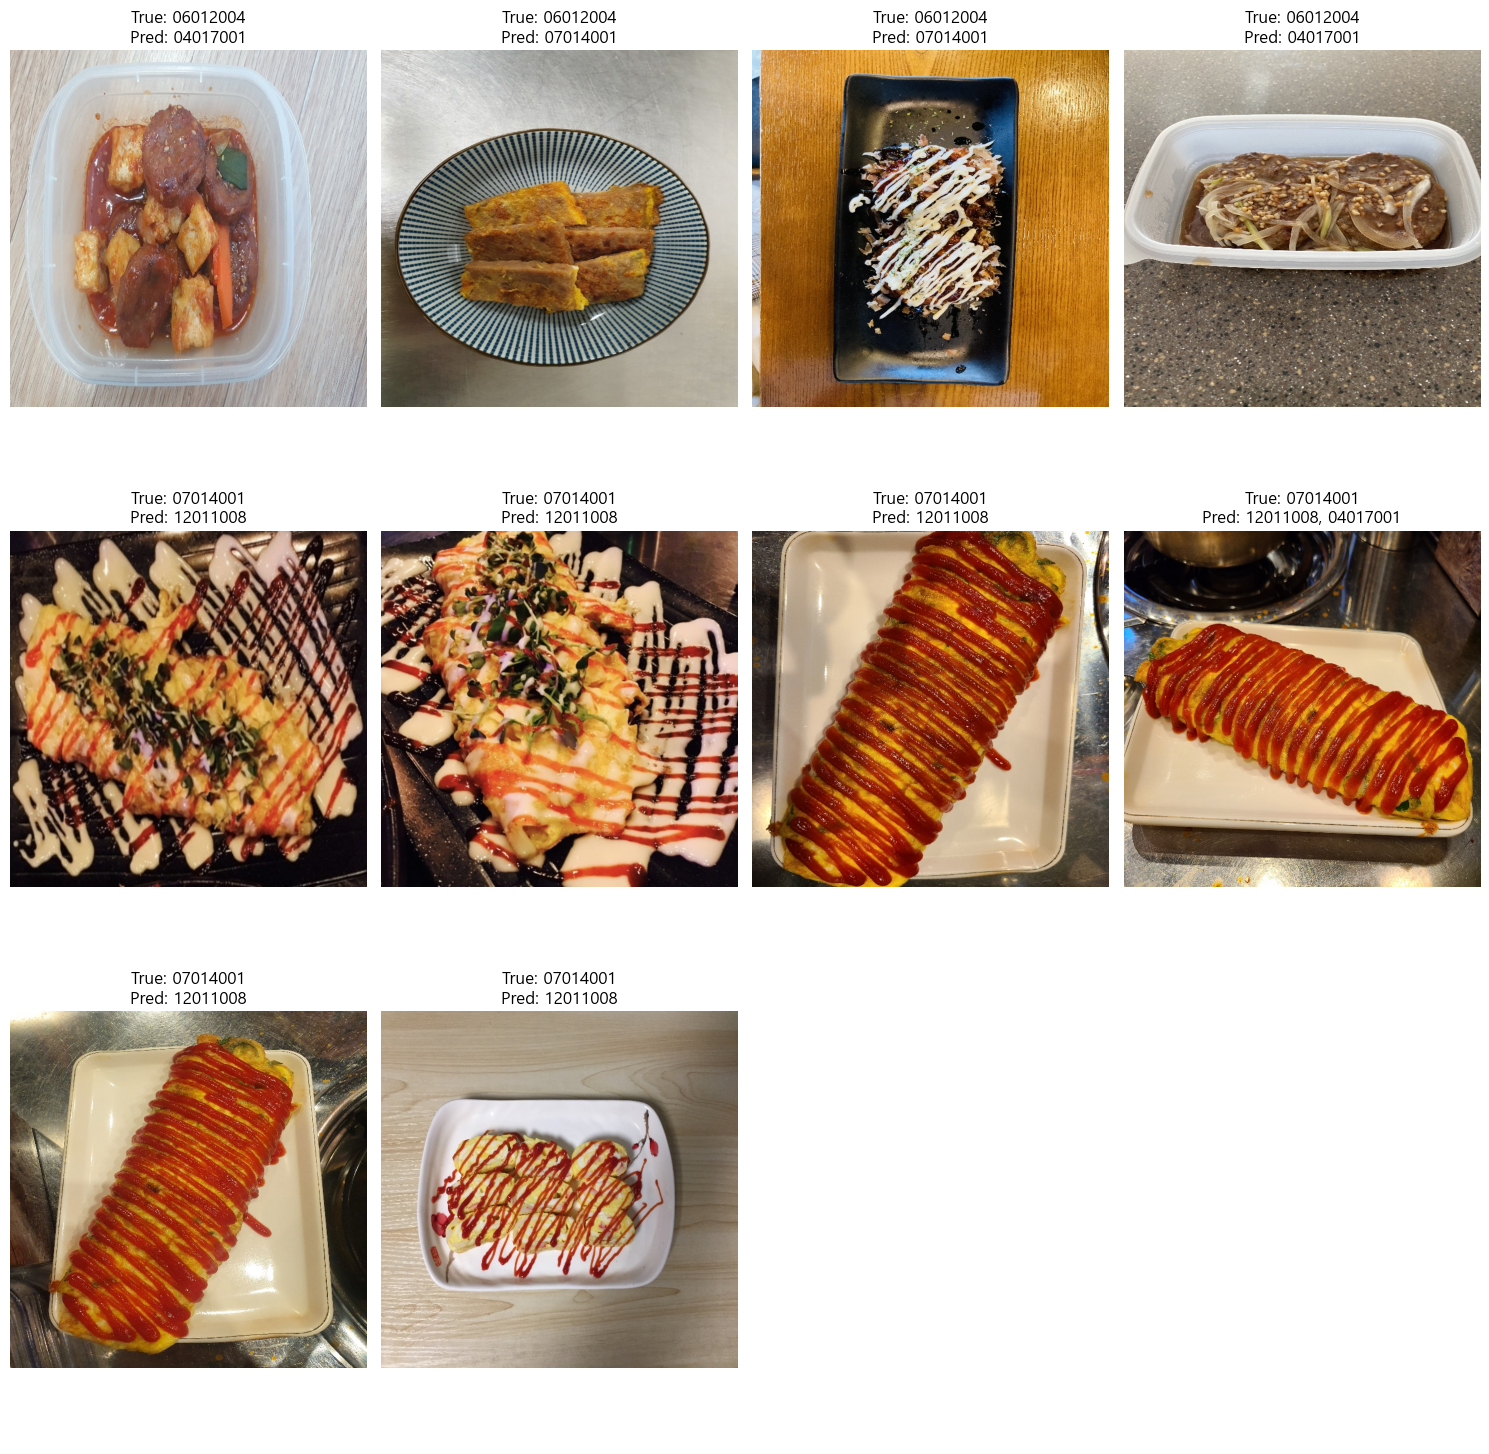

10
잘못 분류된 이미지 개수
여기 들어오니???
4
06012004 : 4
여기 들어오니???
6
07014001 : 6
mis_counts : defaultdict(<class 'int'>, {'06012004': 4, '07014001': 6})


In [50]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from collections import defaultdict

# 모델 경로 및 validation 데이터 경로
model_path = 'best_pt/best.pt'  # 학습된 모델 파일
valid_folder = 'C:/Users/Sesame/food_yolo_detection/1st_seg_data_test_241121/valid'  # Validation 데이터 상위 폴더
classes = sorted(os.listdir(valid_folder))  # 클래스 폴더 이름으로 라벨 추출(valid_folder안에 폴더명을 정렬한 뒤 리스트로 반환)

# 모델 로드
model = YOLO(model_path)

# 잘못 분류된 이미지 저장 리스트
misclassified_images = []
misclassified_counts = defaultdict(int)  # 클래스별 잘못 분류된 이미지 개수 저장

# Validation 데이터 처리
for label_idx, class_name in enumerate(classes):
    print(f'classes : {classes}')   
    print(f'label_idx : {label_idx}')
    print(f'class_name : {class_name}')

    # classes : ['01011001', '04017001', '06012004', '07014001', '11013007', '12011008']
    # label_idx : 0
    # class_name : 01011001

    class_image_folder = os.path.join(valid_folder, class_name, 'images')
    if not os.path.exists(class_image_folder):
        continue

    image_files = [f for f in os.listdir(class_image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_file in image_files:
        # 이미지 로드 및 모델 예측
        image_path = os.path.join(class_image_folder, image_file)
        image = cv2.imread(image_path)
        # resized_image = cv2.resize(image, (640, 480))  # 이미지 크기 조정

        results = model(image)
        pred_classes = [int(box.cls.item()) for box in results[0].boxes]  # 모델 예측값

        # 예측값이 라벨값과 다른 경우 저장
        if label_idx not in pred_classes:
            misclassified_images.append((image, class_name, pred_classes))
            misclassified_counts[class_name] += 1  # 클래스별 카운트 증가
            
# 잘못 분류된 이미지 시각화
def plot_misclassified(images_with_labels):
    """잘못 분류된 이미지를 n행 × n열 그리드로 시각화"""
    total_images = len(images_with_labels)
    # print(f'잘못된거 몇개인지 확인 : 함수안에서 {total_images}')
    cols = 4  # 한 줄에 표시할 이미지 수
    rows = (total_images // cols) + 1 if total_images % cols != 0 else total_images // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, (img, true_label, pred_labels) in enumerate(images_with_labels):
        ax = axes.flatten()[i] if i < rows * cols else None
        if ax:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            pred_text = ', '.join(classes[p] for p in pred_labels)
            ax.set_title(f"True: {true_label}\nPred: {pred_text}")
            ax.axis('off')
    # 남은 빈 칸은 비활성화
    for j in range(i + 1, rows * cols):
        axes.flatten()[j].axis('off')
    plt.tight_layout()
    plt.show()

if total_images > 0:
    plot_misclassified(misclassified_images)
else:
    print("모든 Validation 데이터가 올바르게 분류되었습니다.")


# 잘못 분류된 전체 이미지 갯수 출력하기 
print(len(misclassified_images))
# 클래스를 잘못 분류한 이미지 갯수 출력 
print('잘못 분류된 이미지 개수')

for class_name, count in misclassified_counts.items():
    print("여기 들어오니???") # misclassified_counts가 빈 딕셔너리인 경우 for 코드 실행불가
    print(count)
    print(f'{class_name} : {count}')
print(f'mis_counts : {misclassified_counts}')
